In [84]:

%matplotlib inline
from __future__ import division, print_function
from gensim import models
from keras import datasets
from keras import layers
from keras import losses
from keras import models
from keras import utils

from keras.callbacks import History
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers import Flatten
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.models import Sequential

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from platform import python_version
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.autograd import Variable
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
import collections
import gensim
import itertools
import keras
import logging
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import sklearn
import string
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import transformers
print(tf.keras.__version__)




2.7.0


In [85]:
data = pd.read_csv('dev.csv')
data.columns = ['Text', 'Label']
data.head(50)

,Text,Label
0,Buses approaching to this place is highly unsafe.,1
1,a man was commenting at me.,1
2,in a share auto,0
3,I was coming out of a club at night with a few...,1
4,One of my friends was molested in the crowd. T...,0
5,I was travelling in metro heading to my colleg...,0
6,A guy masturbating at the roadside and ogling....,1
7,"When I was travelling in red line metro , a gu...",0
8,Late evening (around 7.30 pm) after shopping i...,0
9,For a week in the morning when I found be taki...,1


In [63]:
np.random.seed(5)

In [64]:
data.Label.unique()

array([1, 0], dtype=int64)

In [65]:
data.shape

(991, 2)

In [66]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [67]:
data['Pos']= pos
data['Neg']= neg

In [68]:
data.head()

,Text,Label,Pos,Neg
0,Buses approaching to this place is highly unsafe.,1,1,0
1,a man was commenting at me.,1,1,0
2,in a share auto,0,0,1
3,I was coming out of a club at night with a few...,1,1,0
4,One of my friends was molested in the crowd. T...,0,0,1


# Cleaning the data

In [69]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [70]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean] 

In [71]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]  
lower_tokens = [lower_token(token) for token in tokens] 

In [72]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [73]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [74]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [75]:
result = [' '.join(sen) for sen in filtered_words] 

In [76]:
data['Text_Final'] = result

In [77]:
data['tokens'] = filtered_words

In [78]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [79]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,buses approaching place highly unsafe,"[buses, approaching, place, highly, unsafe]",1,1,0
1,man commenting,"[man, commenting]",1,1,0
2,share auto,"[share, auto]",0,0,1
3,coming club night friends guys came stopped us...,"[coming, club, night, friends, guys, came, sto...",1,1,0


# Split data into test and train

In [80]:
data_train, data_test = train_test_split(data, test_size=500, random_state=42)



In [81]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

5290 words total, with a vocabulary size of 1753
Max sentence length is 102


In [82]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

5473 words total, with a vocabulary size of 1816
Max sentence length is 116


# Load Google News Word2Vec model

In [83]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

AttributeError: module 'keras.models' has no attribute 'KeyedVectors'

In [23]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [24]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# Get Embeddings

In [25]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [26]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

# Tokenize and Pad Sequences

In [27]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 2634 unique tokens.


In [28]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(2635, 300)


In [30]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define CNN

In [31]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [32]:
label_names = ['Pos', 'Neg']

In [33]:
y_train = data_train[label_names].values

In [34]:
x_train = train_cnn_data
y_tr = y_train

In [35]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      790500      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

# Train CNN

In [36]:
num_epochs = 200
batch_size = 40

In [37]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/200
21/21 [==============================] - 2s 46ms/step - loss: 0.6836 - acc: 0.6005 - val_loss: 0.6000 - val_acc: 0.7111
Epoch 2/200
21/21 [==============================] - 1s 36ms/step - loss: 0.5152 - acc: 0.7628 - val_loss: 0.5484 - val_acc: 0.7667
Epoch 3/200
21/21 [==============================] - 1s 36ms/step - loss: 0.4140 - acc: 0.8177 - val_loss: 0.5658 - val_acc: 0.7667
Epoch 4/200
21/21 [==============================] - 1s 36ms/step - loss: 0.2958 - acc: 0.8777 - val_loss: 0.5645 - val_acc: 0.7667
Epoch 5/200
21/21 [==============================] - 1s 36ms/step - loss: 0.1768 - acc: 0.9463 - val_loss: 0.5804 - val_acc: 0.8000
Epoch 6/200
21/21 [==============================] - 1s 37ms/step - loss: 0.1276 - acc: 0.9650 - val_loss: 0.6549 - val_acc: 0.7778
Epoch 7/200
21/21 [==============================] - 1s 36ms/step - loss: 0.0788 - acc: 0.9800 - val_loss: 0.8435 - val_acc: 0.6778
Epoch 8/200
21/21 [==============================] - 1s 36ms/step - loss: 0.

21/21 [==============================] - 1s 45ms/step - loss: 0.0302 - acc: 0.9850 - val_loss: 1.2549 - val_acc: 0.7889
Epoch 63/200
21/21 [==============================] - 1s 50ms/step - loss: 0.0289 - acc: 0.9850 - val_loss: 1.2037 - val_acc: 0.7778
Epoch 64/200
21/21 [==============================] - 1s 43ms/step - loss: 0.0291 - acc: 0.9863 - val_loss: 1.2401 - val_acc: 0.7778
Epoch 65/200
21/21 [==============================] - 1s 40ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 1.2653 - val_acc: 0.7889
Epoch 66/200
21/21 [==============================] - 1s 41ms/step - loss: 0.0292 - acc: 0.9875 - val_loss: 1.2353 - val_acc: 0.7778
Epoch 67/200
21/21 [==============================] - 1s 42ms/step - loss: 0.0299 - acc: 0.9850 - val_loss: 1.3106 - val_acc: 0.7889
Epoch 68/200
21/21 [==============================] - 1s 40ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 1.2562 - val_acc: 0.7778
Epoch 69/200
21/21 [==============================] - 1s 38ms/step - loss: 0.0273 

21/21 [==============================] - 1s 38ms/step - loss: 0.0891 - acc: 0.9750 - val_loss: 1.0604 - val_acc: 0.7444
Epoch 124/200
21/21 [==============================] - 1s 50ms/step - loss: 0.0505 - acc: 0.9800 - val_loss: 1.2604 - val_acc: 0.7222
Epoch 125/200
21/21 [==============================] - 1s 49ms/step - loss: 0.1330 - acc: 0.9501 - val_loss: 1.1082 - val_acc: 0.7889
Epoch 126/200
21/21 [==============================] - 1s 39ms/step - loss: 0.0656 - acc: 0.9763 - val_loss: 1.3018 - val_acc: 0.7556
Epoch 127/200
21/21 [==============================] - 1s 46ms/step - loss: 0.0485 - acc: 0.9813 - val_loss: 1.2794 - val_acc: 0.7667
Epoch 128/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0351 - acc: 0.9825 - val_loss: 1.3903 - val_acc: 0.7556
Epoch 129/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0354 - acc: 0.9850 - val_loss: 1.3369 - val_acc: 0.7889
Epoch 130/200
21/21 [==============================] - 1s 36ms/step - loss: 

21/21 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 1.8731 - val_acc: 0.7444
Epoch 185/200
21/21 [==============================] - 1s 41ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 1.8714 - val_acc: 0.7444
Epoch 186/200
21/21 [==============================] - 1s 36ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 1.8719 - val_acc: 0.7444
Epoch 187/200
21/21 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 1.8639 - val_acc: 0.7444
Epoch 188/200
21/21 [==============================] - 1s 36ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 1.8636 - val_acc: 0.7333
Epoch 189/200
21/21 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 1.8979 - val_acc: 0.7333
Epoch 190/200
21/21 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 1.9070 - val_acc: 0.7333
Epoch 191/200
21/21 [==============================] - 1s 35ms/step - loss: 

# Test CNN

In [38]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 136ms/step


In [39]:
labels = [1, 0]

In [40]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [41]:
data_test.Label.value_counts()

0    60
1    40
Name: Label, dtype: int64

In [42]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.78

Text(23.999999999999993, 0.5, 'Actual')

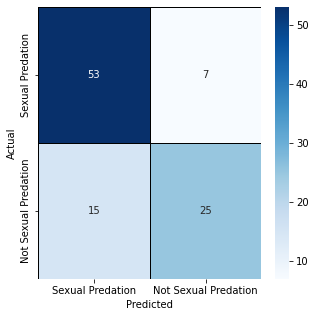

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data_test.Label, prediction_labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Sexual Predation','Not Sexual Predation'], 
            yticklabels = ['Sexual Predation','Not Sexual Predation'])
plt.xlabel("Predicted")
plt.ylabel("Actual")